<a href="https://colab.research.google.com/github/jwalx/Tensorflow/blob/main/08_Tensorflow_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NLP has the goal of deriving information out of natural language(could be sequence text or speech).
Another common term for NLP problem is sequence to sequence problem(seq2seq)

In [1]:
import tensorflow as tf

In [2]:
#Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-75ed0d78-3063-34ae-7847-2b7e631f4b5e)


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-17 22:34:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-17 22:34:36 (96.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import unzip_data,create_tensorboard_callback,compare_historys,plot_loss_curves

In [5]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"


--2023-05-17 22:34:38--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 173.194.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-05-17 22:34:38 (113 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [6]:
unzip_data("nlp_getting_started.zip")

In [7]:
import pandas as pd
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
# To shuffle data
train_df_shuffled=train_df.sample(frac=1,random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [9]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
#how many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [11]:
len(train_df),len(test_df)

(7613, 3263)

In [12]:
# Visualizing random training examples
import random
random_index = random.randint(0,len(train_df)-10) #not higher than total number of examples
for row in train_df_shuffled[["text","target"]][random_index:random_index+10].itertuples():
  _,text,target=row
  print(f"Target:{target}","(real disaster)" if target > 0 else"(not real disaster)")
  print(f"Text:\n{text}\n")
  print("----\n")

Target:0 (not real disaster)
Text:
I'm only experienced with injuries below the waist

----

Target:0 (not real disaster)
Text:
So happy to be exercised of the demon of @ATT. Price kept rising service kept sinking. #goodbye

----

Target:0 (not real disaster)
Text:
You da One 

#MTVSummerStar #VideoVeranoMTV  #MTVHottest Britney Spears Lana Del Rey

----

Target:1 (real disaster)
Text:
Cos sanity brings no reward for one more hit and one last score... Don't be a casualty cut the cord...

----

Target:1 (real disaster)
Text:
I'll be at SFA very soon....#Pandemonium http://t.co/RW8b50xz9m

----

Target:0 (not real disaster)
Text:
I feel that 'crash and burn' by Thomas Rhett for sure

----

Target:0 (not real disaster)
Text:
@VZWSupport do texts use data? She was inundated by a group text yesterday.

----

Target:0 (not real disaster)
Text:
What's cool is that teens are becoming what I like to call 'digital first responders' for their friends who need a little help or support !!

----

Ta

In [13]:
## spliting data into training and validation dataset
from sklearn.model_selection import train_test_split

In [14]:
train_sentences,val_sentences,train_labels,val_labels=train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                       train_df_shuffled["target"].to_numpy(),
                                                                       test_size=0.1,   #use 10% of training data for validation
                                                                       random_state=42)

In [15]:
len(train_sentences),len(val_sentences),len(train_labels),len(val_labels)

(6851, 762, 6851, 762)

In [16]:
train_sentences[:10],train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers
 when dealing with text problems, one of tge first things required is converting text into numbers

 few ways of doing it is:
 
 1)Tokenization - direct mapping of token(better for smaller problems)
 
 2)Embedding - create a matrix of feature vector for each token

In [17]:
# Tokenization
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

#use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in vocabulary
                                    standardize = "lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, #create groups
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) #how long the seqence should be
                                    #pad_to_max_tokens=True)

In [18]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [19]:
max_vocab_length=10000
max_length =15

text_vectorizer=TextVectorization(max_tokens=max_vocab_length,
                                  output_mode="int",
                                  output_sequence_length=max_length)

In [20]:
# fit the text vectorizer to the tokenize it 
text_vectorizer.adapt(train_sentences)

In [21]:
#create a sample senetence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [22]:
#choose random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 RT @kotowsa: South SudanÛªs war on women: survivors say rape has become 'just a normal thing' 
https://t.co/MexwoHd3TG http://t.co/gB46FiD2wE        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  96,    1,  593, 7966,  122,   11,  427,  362,  132, 2328,   41,
         791,   29,    3, 2370]])>

In [23]:
#get the unique words in the vocalbulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all the unique words in our training data 
top_5_words = words_in_vocab[:5]  # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words 

In [24]:
print(f"number of words in vocab: {len(words_in_vocab)}")
print(f"most common words in vocab: {top_5_words}")
print(f"least common words in vocab: {bottom_5_words}")

number of words in vocab: 10000
most common words in vocab: ['', '[UNK]', 'the', 'a', 'in']
least common words in vocab: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Embedding layer

In [25]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [26]:
random_sentence=random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\n\n embedding version:")

sample_embed=embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
So Pardon me while I burst into flames. 

I've had enough of the world and its people's mindless games

 embedding version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03159565,  0.0217896 , -0.01229495, ..., -0.01901594,
         -0.02527297,  0.04707793],
        [ 0.02984308, -0.02614864,  0.0390189 , ...,  0.04289982,
         -0.04412022, -0.00968878],
        [-0.02194107,  0.0423778 ,  0.01773281, ..., -0.00910306,
         -0.00374382,  0.04392281],
        ...,
        [-0.04400152,  0.04842809,  0.04448942, ...,  0.02418307,
         -0.03694228, -0.0393662 ],
        [-0.01839566,  0.01166479,  0.02471441, ...,  0.01875735,
          0.04941886,  0.02106733],
        [-0.04483912, -0.02124721,  0.04584831, ...,  0.01582273,
         -0.04197577, -0.03479956]]], dtype=float32)>

In [27]:
# check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.03159565,  0.0217896 , -0.01229495,  0.00304596,  0.04859189,
       -0.01169499, -0.03366818, -0.00596148,  0.04927318,  0.00640491,
        0.03791561,  0.00969625,  0.03095479,  0.00989763, -0.00595055,
        0.04826367, -0.01827485,  0.04477421, -0.01780164, -0.00684241,
        0.04224129,  0.0199914 , -0.01465399,  0.03210021, -0.00778664,
        0.04535535,  0.04142394,  0.0223081 ,  0.00245314,  0.00860939,
       -0.02010598,  0.04340648, -0.03574599,  0.04105196,  0.04474073,
        0.04279648,  0.03717773, -0.01795774,  0.0478597 , -0.03526151,
        0.02144435,  0.02386916, -0.03899897,  0.01774501, -0.04334637,
        0.04478982, -0.04862265, -0.01752705,  0.04301716, -0.02916282,
        0.02561111,  0.006794  , -0.02787424, -0.04539421,  0.01043127,
       -0.00533416, -0.02619454,  0.03665156,  0.00100102,  0.01731663,
       -0.04481569,  0.03055221, -0.01047922,  0.03041217,  0.01146104,
        0.021778

Now that we've got a way to turn our text data into numbers, we can start to build machine learning models to model it.

To get plenty of practice, we're going to build a series of different models, each as its own experiment. We'll then compare the results of each model and see which one performed best.

More specifically, we'll be building the following:

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data
* Model 0 is the simplest to acquire a baseline which we'll expect each other of the other deeper models to beat.

Each experiment will go through the following steps:

Construct the model
Train the model
Make predictions with the model
Track prediction evaluation metrics for later comparison
Let's get started.

# Getting started with Model:0

Using Non-Deep learning algorithms as a baseline because of their speed and then later Deep learning to see if you can improve.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [29]:
# Create tokenization and modeling pipeline
model_0 = Pipeline([
                    ("tfidf",TfidfVectorizer()), # convert words to number using tfidf
                    ("clf",MultinomialNB())   # model to text
])

#Fit the pipeline to the training data
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
baseline_score=model_0.score(val_sentences,val_labels)
print(f"accuracy of our baseline model is:{baseline_score*100:.2f}% ")


accuracy of our baseline model is:79.27% 


In [31]:
# make predictions
baseline_preds=model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

# Creating an evaluation metrics for our model experiments

We could evaluate these as they are but since we're going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:

Accuracy
Precision
Recall
F1-score


In [32]:
# function to evaluate:accuracy_score,precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true,y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy=accuracy_score(y_true,y_pred) *100

  # Calculate model precision,recall and f1 score using weighted average
  model_precision,model_recall,model_f1,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
  model_results = {"accuracy" :model_accuracy,
                   "precision":model_precision,
                   "recall":model_recall,
                   "f1":model_f1}

  return model_results

In [33]:
# get baseline results
baseline_results=calculate_results(y_true=val_labels,
                                   y_pred=baseline_preds)

# Model_1: A Simple dense model

In [34]:
# importing tensorflow callback function from helper function
from helper_functions import create_tensorboard_callback

# Create directory to save Tensorboard Logs
SAVE_DIR = "model_logs"


In [35]:
# lets build our simple dense model
from tensorflow.keras import layers
inputs=tf.keras.layers.Input(shape=(1,),dtype="string")
x= text_vectorizer(inputs)
x=embedding(x)
x=tf.keras.layers.GlobalAveragePooling1D()(x)
outputs=tf.keras.layers.Dense(1,activation="sigmoid")(x)
model_1=tf.keras.Model(inputs,outputs,name="model_1_dense")

In [36]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [37]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [38]:
model_1_history=model_1.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                   experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230517-223446
Epoch 1/5
215/215 [==============================] - 27s 85ms/step - loss: 0.6115 - accuracy: 0.6913 - val_loss: 0.5375 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4423 - accuracy: 0.8194 - val_loss: 0.4693 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3472 - accuracy: 0.8600 - val_loss: 0.4588 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2856 - accuracy: 0.8915 - val_loss: 0.4637 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2387 - accuracy: 0.9129 - val_loss: 0.4759 - val_accuracy: 0.7861


In [39]:
# check the results
model_1.evaluate(val_sentences,val_labels)


24/24 [==============================] - 0s 3ms/step - loss: 0.4759 - accuracy: 0.7861


[0.475909948348999, 0.7860892415046692]

In [40]:
# lets make some predictions
model_1_pred_probs=model_1.predict(val_sentences)
# top 10 predictions
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.41632155],
       [0.7452384 ],
       [0.99798065],
       [0.1137903 ],
       [0.11188071],
       [0.93371993],
       [0.9125591 ],
       [0.9927776 ],
       [0.9704011 ],
       [0.25890616]], dtype=float32)

In [41]:
val_labels

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,

In [42]:
#Convert model prediction probabilites to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [43]:
#calculate our model results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [44]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [45]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

# Looks like our baseline model outperforms our model_1

# Visualizing learned embeddings

In [46]:
# get the vocabulary from the text vectorizer layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab),words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [47]:
#model 1 Summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [48]:
# get the weight of embedding layer
embed_weights=model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [49]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.61, Difference: -0.66
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


Now we've got the embedding matrix our model has learned to represent our tokens,let's see how can we visualize it

To do so, Tensorflow has a handy tool called projector

And tensorflow also has an incredible guide for word embeddings

In [50]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [51]:
# download files from colab to upload to projector:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("vectors.tsv")
  files.download("metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## LSTM

In [52]:
tf.random.set_seed(42)
model_2_embedding=tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                             output_dim=128,
                                             embeddings_initializer="uniform",
                                             input_length=max_length,
                                             name="embedding_2")

# create Lstm
inputs=tf.keras.layers.Input(shape=(1,),dtype="string")
x=text_vectorizer(inputs)
x=model_2_embedding(x)
print(x.shape)

x=tf.keras.layers.LSTM(64)(x)
print(x.shape)

outputs=tf.keras.layers.Dense(1,activation="sigmoid")(x)
model_2=tf.keras.Model(inputs,outputs,name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [53]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [55]:
model_2_history=model_2.fit(train_sentences,train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230517-223531
Epoch 1/5
215/215 [==============================] - 15s 53ms/step - loss: 0.5129 - accuracy: 0.7440 - val_loss: 0.4604 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3199 - accuracy: 0.8695 - val_loss: 0.5072 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2230 - accuracy: 0.9155 - val_loss: 0.5704 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1592 - accuracy: 0.9442 - val_loss: 0.6301 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1124 - accuracy: 0.9590 - val_loss: 0.8009 - val_accuracy: 0.7677


In [56]:
model_2_pred_probs=model_2.predict(val_sentences)
model_2_pred_probs.shape,model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.03148536],
        [0.74819416],
        [0.99939036],
        [0.06334317],
        [0.00631159],
        [0.99940264],
        [0.87558603],
        [0.9996201 ],
        [0.99933904],
        [0.23887196]], dtype=float32))

In [57]:
model_2_preds=tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [58]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results


{'accuracy': 76.77165354330708,
 'precision': 0.768489862704666,
 'recall': 0.7677165354330708,
 'f1': 0.7660466459325422}

In [59]:
compare_baseline_to_new_results(baseline_results,model_2_results)

Baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Model 3 : GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.


In [60]:
# build an RNN using GRU Layer
inputs =tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)
x=tf.keras.layers.GRU(64)(x)   # if you want to stack recurrent layers 
# x= tf.keras.layers.LSTM(64,return_sequences=True)(x)
# x= tf.keras.layers.GRU(x)
# x= tf.keras.layers.Dense(64,activation="relu")(x)
outputs=tf.keras.layers.Dense(1,activation="sigmoid")(x)
model_3=tf.keras.Model(inputs,outputs,name="model_3_GRU")

In [61]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [62]:
#get a summary of GRU model
model_3.summary()


Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [63]:
model_3_history=model_3.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                       "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230517-223615
Epoch 1/5
215/215 [==============================] - 14s 52ms/step - loss: 0.2308 - accuracy: 0.9094 - val_loss: 0.5332 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1607 - accuracy: 0.9413 - val_loss: 0.5939 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 4s 16ms/step - loss: 0.1290 - accuracy: 0.9526 - val_loss: 0.7537 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1103 - accuracy: 0.9606 - val_loss: 0.7543 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0922 - accuracy: 0.9657 - val_loss: 0.7264 - val_accuracy: 0.7900


In [64]:
model_3_pred_probs=model_3.predict(val_sentences)
model_3_pred_probs.shape,model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.06940957],
        [0.81403273],
        [0.99958843],
        [0.05161505],
        [0.00106138],
        [0.9919057 ],
        [0.6768154 ],
        [0.99974304],
        [0.9994943 ],
        [0.6311517 ]], dtype=float32))

In [65]:
model_3_preds=tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [66]:
model_3_results=calculate_results(y_true=val_labels,
                                  y_pred=model_3_preds)
model_3_results

{'accuracy': 79.00262467191601,
 'precision': 0.7924477622115417,
 'recall': 0.7900262467191601,
 'f1': 0.78800214661143}

In [67]:
compare_baseline_to_new_results(baseline_results,model_3_results)

Baseline accuracy: 79.27, New accuracy: 79.00, Difference: -0.26
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.00
Baseline f1: 0.79, New f1: 0.79, Difference: 0.00


# BI-Directional RNN

In [68]:
tf.random.set_seed(42)
model_4_embedding=tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                            output_dim=128,
                                            embeddings_initializer="uniform",
                                            input_length=max_length,
                                            name="embedding_4")

inputs=tf.keras.layers.Input(shape=(1,),dtype="string")
x=text_vectorizer(inputs)
x=model_4_embedding(x)
x=tf.keras.layers.Bidirectional(layers.LSTM(64))(x)
outputs=tf.keras.layers.Dense(1,activation="sigmoid")(x)
model_4=tf.keras.Model(inputs,outputs,name="model_4_Bidirectional")

In [69]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [70]:
model_4.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fd8ca2bb7f0>>

In [71]:
model_4_history=model_4.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,"bidirectional_RNN")])


Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230517-223659
Epoch 1/5
215/215 [==============================] - 17s 55ms/step - loss: 0.5093 - accuracy: 0.7451 - val_loss: 0.4599 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3135 - accuracy: 0.8724 - val_loss: 0.5251 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2138 - accuracy: 0.9183 - val_loss: 0.5615 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1487 - accuracy: 0.9512 - val_loss: 0.6360 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1054 - accuracy: 0.9653 - val_loss: 0.6478 - val_accuracy: 0.7664


In [72]:
model_4_pred_probs=model_4.predict(val_sentences)
model_4_pred_probs.shape,model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


((762, 1),
 array([[0.055469  ],
        [0.8245624 ],
        [0.99899465],
        [0.15004966],
        [0.00750444],
        [0.99656844],
        [0.9699584 ],
        [0.99967873],
        [0.9995858 ],
        [0.24474278]], dtype=float32))

In [73]:
model_4_preds=tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [74]:
model_4_results=calculate_results(val_labels,model_4_preds)

In [75]:
compare_baseline_to_new_results(baseline_results,model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.64, Difference: -2.62
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


## Convolutional Neural networks for Text(and other types of sequences)

We've used the CNNs for images aere typically 2D (height x width)... however, our text data is 1D

Previously we've Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for a seqence(in our case,text):

input(text) -> Tokenization -> Layer(s) (typically Conv1D + pooling -> outputs(class probabilites)

## Model 5 :Conv1D

In [76]:
# Test out our embedding layer, Conv1D and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = tf.keras.layers.Conv1D(filters =32,
                                 kernel_size=5,
                                 strides=1,  #default
                                 activation="relu",
                                 padding="valid")
conv_1d_output = conv_1d(embedding_test)  # pass test embedding through conv1d layer
max_pool=tf.keras.layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)  #  equivalent to get the most important feature or getting the feature with highes value

In [77]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00632009,  0.04696548, -0.07126011, ...,  0.05957669,
          0.004233  ,  0.04657004],
        [-0.01873479, -0.02164224, -0.00247655, ...,  0.01525112,
          0.05742959,  0.0047688 ],
        [ 0.01907415, -0.00639288, -0.01608883, ...,  0.00074458,
         -0.01944173,  0.01952318],
        ...,
        [ 0.0028658 ,  0.0081385 , -0.00888548, ...,  0.0484535 ,
         -0.01615724,  0.00167092],
        [ 0.0028658 ,  0.0081385 , -0.00888548, ...,  0.0484535 ,
         -0.01615724,  0.00167092],
        [ 0.0028658 ,  0.0081385 , -0.00888548, ...,  0.0484535 ,
         -0.01615724,  0.00167092]]], dtype=float32)>

In [78]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , 0.        , 0.01040708,
         0.00061369, 0.05062573, 0.        , 0.07725839, 0.        ,
         0.01034045, 0.0170229 , 0.        , 0.02969794, 0.04813947,
         0.        , 0.01350066, 0.07461974, 0.045705  , 0.0854528 ,
         0.00438965, 0.06373765, 0.        , 0.00736425, 0.        ,
         0.03208873, 0.        , 0.        , 0.        , 0.03663076,
         0.        , 0.        ],
        [0.        , 0.01844662, 0.04473668, 0.        , 0.02151489,
         0.        , 0.        , 0.03036092, 0.02203413, 0.        ,
         0.        , 0.        , 0.05483115, 0.        , 0.        ,
         0.        , 0.0089943 , 0.        , 0.03206874, 0.        ,
         0.01553962, 0.0247069 , 0.0494424 , 0.00579447, 0.        ,
         0.03697214, 0.        , 0.        , 0.03549857, 0.        ,
         0.00220495, 0.        ],
        [0.0395164 , 0.        , 0.00552733, 0.    

In [79]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.0395164 , 0.01844662, 0.04473668, 0.        , 0.0471279 ,
        0.00061369, 0.05062573, 0.03036092, 0.07725839, 0.        ,
        0.01034045, 0.0170229 , 0.05483115, 0.05464452, 0.04813947,
        0.02680257, 0.09111203, 0.07461974, 0.11106297, 0.0854528 ,
        0.05682647, 0.0640842 , 0.06821199, 0.00736425, 0.06741478,
        0.07650717, 0.06662296, 0.04058048, 0.05025216, 0.03663076,
        0.00768196, 0.        ]], dtype=float32)>

In [80]:
# Create 1-dimensional convolutional layer to model sequences
inputs= tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x= text_vectorizer(inputs)
x=embedding(x)
x=tf.keras.layers.Conv1D(filters=64,kernel_size=5,strides=1,activation="relu",padding="valid")(x)
x=tf.keras.layers.GlobalMaxPool1D()(x)

outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model_5=tf.keras.Model(inputs,outputs,name="model_5_Conv_1D")

#compile Conv1D
model_5.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model_5.summary() 

Model: "model_5_Conv_1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)             

In [81]:
# Fit the model
model_5_history=model_5.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230517-223732
Epoch 1/5
215/215 [==============================] - 13s 50ms/step - loss: 0.1520 - accuracy: 0.9492 - val_loss: 0.7420 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1024 - accuracy: 0.9623 - val_loss: 0.8831 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0806 - accuracy: 0.9688 - val_loss: 0.9603 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 2s 12ms/step - loss: 0.0695 - accuracy: 0.9733 - val_loss: 1.0458 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0609 - accuracy: 0.9755 - val_loss: 1.1116 - val_accuracy: 0.7703


In [82]:
# make some predictions with Conv1D model
model_5_pred_probs=model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[3.0337131e-01],
       [6.0401183e-01],
       [9.9996185e-01],
       [5.7312679e-02],
       [2.1734229e-07],
       [9.9795270e-01],
       [9.8937631e-01],
       [9.9981707e-01],
       [9.9999881e-01],
       [6.8715465e-01]], dtype=float32)

In [83]:
# Convert model 5 pred probs to labels
model_5_preds=tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [84]:
# evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 77.03412073490814,
 'precision': 0.7709806133638261,
 'recall': 0.7703412073490814,
 'f1': 0.7688058109983439}

In [85]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 6 : Tensorflow Hub pretrained Sentences Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using tensorflow hub's universal sentence encoder

In [86]:
sample_sentence

"There's a flood in my street!"

In [87]:
import tensorflow_hub as hub
embed=hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples=embed([sample_sentence,
                     "when you call the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [88]:
# create a keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      input_shape=[],
                                      dtype=tf.string,
                                      trainable=False,
                                      name="USE")

In [89]:
# create model using the Sequential API
model_6 =tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(1,activation = "sigmoid")
],name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [90]:
# train a classifier on top of USE pretrained embeddings
model_6.history=model_6.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    "tf_hub_sentence_enocoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_enocoder/20230517-223844
Epoch 1/5
215/215 [==============================] - 6s 14ms/step - loss: 0.5007 - accuracy: 0.7865 - val_loss: 0.4517 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4154 - accuracy: 0.8145 - val_loss: 0.4401 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4009 - accuracy: 0.8215 - val_loss: 0.4355 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3935 - accuracy: 0.8262 - val_loss: 0.4304 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3871 - accuracy: 0.8307 - val_loss: 0.4324 - val_accuracy: 0.8136


In [91]:
model_6_pred_probs=model_6.predict(val_sentences)
model_6_pred_probs[:10]


24/24 [==============================] - 1s 9ms/step


array([[0.15667343],
       [0.72780603],
       [0.9830921 ],
       [0.2031205 ],
       [0.72648084],
       [0.6771876 ],
       [0.9771961 ],
       [0.9728258 ],
       [0.9187684 ],
       [0.08998299]], dtype=float32)

In [92]:
model_6_preds=tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [93]:
model_6_results= calculate_results(y_true=val_labels,
                                   y_pred=model_6_preds)
model_6_results


{'accuracy': 81.36482939632546,
 'precision': 0.8160661319598898,
 'recall': 0.8136482939632546,
 'f1': 0.8120618868299143}

In [94]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [95]:
compare_baseline_to_new_results(baseline_results,model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.36, Difference: 2.10
Baseline precision: 0.81, New precision: 0.82, Difference: 0.00
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.03


# Model & : TF Hub Pretrained USE but with 10% of training data

Transfer learning really hels when you don't have large dataset.

To see how our model performs on a smaller dataset, let's replicate model_6 expect we'll train it on 10% of the data

In [96]:
##  NOTE: Making data splits like below leads to data leakage(model_7 trained on 10% data),outperforms model_6 train on 100% data
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION SETS TO TRAINING SET

# create subsets of 10% of the training data
#train_10_percent = train_df_shuffled[["text","target"]].sample(frac=0.1,random_state=42)
#train_10_percent.head(),len(train_10_percent)
#train_sentences_10_percent=train_10_percent["text"].to_list()
#train_labels_10_percent=train_10_percent["target"].to_list()

## NOTE: Be *very* careful 

When creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks good to be true (a model trained on 10% of data outperforming a model trained on 100% of data) trust your gut and go back to find where the error may lie.

In [97]:
# Making a better dataset split(no data leakage)
train_10_percent_split=int(0.1 * len(train_sentences))
train_sentences_10_percent=train_sentences[:train_10_percent_split]
train_labels_10_percent=train_labels[:train_10_percent_split]


In [98]:
# check the number of each label in updated training
pd.Series(np.array(train_labels_10_percent)).value_counts() 

0    406
1    279
dtype: int64

In [99]:
model_7 =tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid",name="output_layer")
],name="model_7_10_percent")

# compile
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_7.summary()

Model: "model_7_10_percent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [100]:
model_7.history=model_7.fit(train_sentences_10_percent,
                            train_labels_10_percent,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "tf_hub_sentences_hub_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentences_hub_10_percent_correct_split/20230517-223902
Epoch 1/5
22/22 [==============================] - 4s 43ms/step - loss: 0.6601 - accuracy: 0.6861 - val_loss: 0.6383 - val_accuracy: 0.7165
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5865 - accuracy: 0.8044 - val_loss: 0.5798 - val_accuracy: 0.7703
Epoch 3/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5127 - accuracy: 0.8146 - val_loss: 0.5297 - val_accuracy: 0.7782
Epoch 4/5
22/22 [==============================] - 1s 23ms/step - loss: 0.4567 - accuracy: 0.8175 - val_loss: 0.5031 - val_accuracy: 0.7822
Epoch 5/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4181 - accuracy: 0.8350 - val_loss: 0.4881 - val_accuracy: 0.7822


In [101]:
#make prediction with model 7
model_7_pred_probs=model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.17601548],
       [0.598493  ],
       [0.89948404],
       [0.33652613],
       [0.5976892 ],
       [0.6895172 ],
       [0.87268484],
       [0.8247851 ],
       [0.8204019 ],
       [0.13317333]], dtype=float32)

In [102]:
model_7_preds=tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [103]:
model_7_results=calculate_results(y_true=val_labels,
                                  y_pred=model_7_preds)
model_7_results

{'accuracy': 78.21522309711287,
 'precision': 0.7829133858267716,
 'recall': 0.7821522309711286,
 'f1': 0.7807494233675335}

# Comparing the performance of each of our models

In [107]:
# Compare model results into DataFrame
all_model_results=pd.DataFrame({"0_baseline":baseline_results,
                                "1_simple_dense":model_1_results,
                                "2_lstm": model_2_results,
                                "3_gru":model_3_results,
                                "4_bidirectional":model_4_results,
                                "5_conv1d":model_5_results,
                                "6_tf_hub_use_encoder":model_6_results,
                                "7_tf_hub_use_encoder":model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.608924,0.790328,0.786089,0.783297
2_lstm,76.771654,0.768490,0.767717,0.766047
3_gru,79.002625,0.792448,0.790026,0.788002
4_bidirectional,76.640420,0.766730,0.766404,0.765012
5_conv1d,77.034121,0.770981,0.770341,0.768806
6_tf_hub_use_encoder,81.364829,0.816066,0.813648,0.812062
7_tf_hub_use_encoder,78.215223,0.782913,0.782152,0.780749


In [108]:
all_model_results["accuracy"]=all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.786089,0.790328,0.786089,0.783297
2_lstm,0.767717,0.768490,0.767717,0.766047
3_gru,0.790026,0.792448,0.790026,0.788002
4_bidirectional,0.766404,0.766730,0.766404,0.765012
5_conv1d,0.770341,0.770981,0.770341,0.768806
6_tf_hub_use_encoder,0.813648,0.816066,0.813648,0.812062
7_tf_hub_use_encoder,0.782152,0.782913,0.782152,0.780749


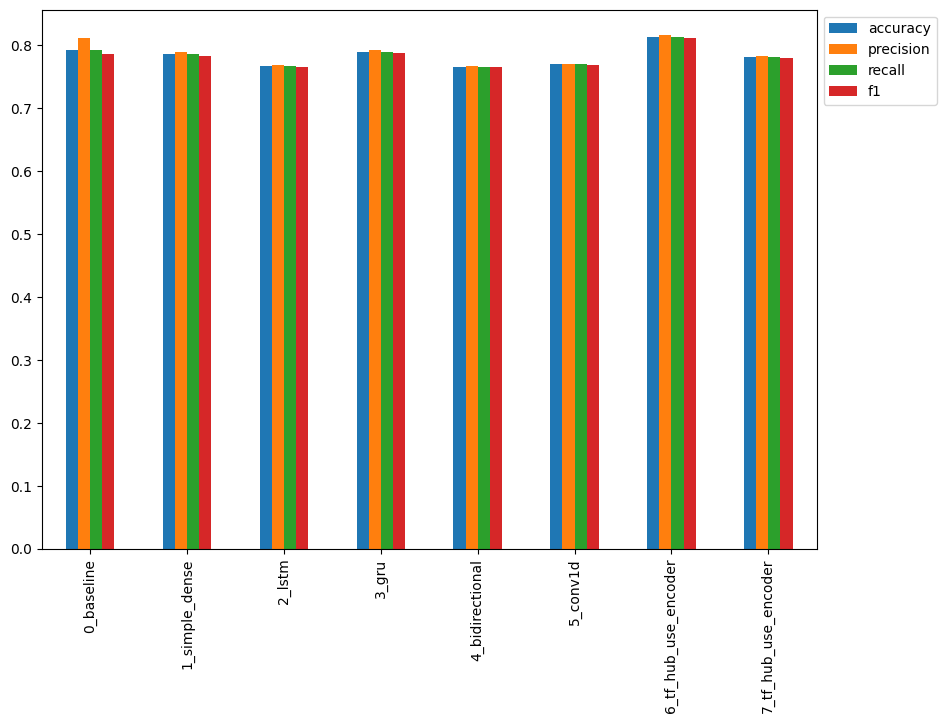

In [111]:
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

<Axes: >

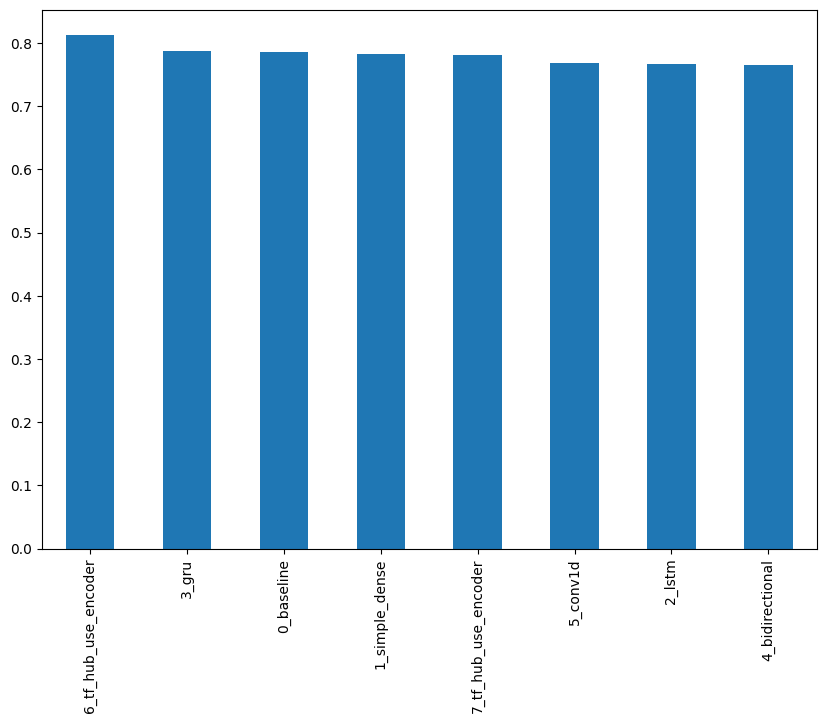

In [114]:
# Sort model prediction by f1-score
all_model_results.sort_values("f1",ascending=False)["f1"].plot(kind="bar",figsize=(10,7))

# Uploading our model training logs to TensorBoard.dev

We can further inspect our model's performance using TensorBoard.dev

In [115]:
# view tensorboard logs to transfer learning modelling experiments(plus all of our models )
# upload Tensorboard dev records
!tensorboard dev uplaod --logdir ./model_logs/ \
  --name "NLP Modelling Experiments" \
  --description "Comparing multiple different types of architectures on the Kaggle tweets classification dataset" \
  --one_shot # exit the uploader once uploading is finished

2023-05-17 22:44:11.042694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard dev
       [-h]
       [--helpfull]
       [--origin ORIGIN]
       [--api_endpoint API_ENDPOINT]
       [--grpc_creds_type {local,ssl,ssl_dev}]
       [--auth_force_console]
       {upload,update-metadata,delete,list,export,auth}
       ...
tensorboard dev: error: argument {upload,update-metadata,delete,list,export,auth}: invalid choice: 'uplaod' (choose from 'upload', 'update-metadata', 'delete', 'list', 'export', 'auth')


# Saving and Laoding models

There are two main formats to save a model in Tensorflow:
1. The HDF5 fromat
2. The *SavedModel* format(this is default when using Tensorflow)



In [116]:
# Save TF Hub Sentences Encoder model to HDF5 format
model_6.save("model_6.h5")


In [118]:
#load model with custom Hub layer(required HDF5 format)
loaded_model_6=tf.keras.models.load_model("model_6.h5",
                                   custom_objects={"KerasLayer":hub.KerasLayer})

In [119]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences,val_labels)


24/24 [==============================] - 1s 10ms/step - loss: 0.4324 - accuracy: 0.8136


[0.43238121271133423, 0.8136482834815979]

In [120]:
model_6_results

{'accuracy': 81.36482939632546,
 'precision': 0.8160661319598898,
 'recall': 0.8136482939632546,
 'f1': 0.8120618868299143}

# The speed/score tradeoff

In [126]:
# let's make a function to measure the time of prediction
import time
def pred_time(model,samples):
   """
   Time how long a model takes to make predictions on samples
   """
   start_time=time.perf_counter() # get start time
   model.predict(samples) # make predictions
   end_time=time.perf_counter() # get finish time
   total_time=end_time-start_time
   time_per_pred=total_time/len(samples)
   return total_time,time_per_pred

In [127]:
# Calculate TF Hub Sentences Encoder time per pred
model_6_total_pred_time,model_6_time_per_pred=pred_time(model=model_6,
                                                         samples=val_sentences)
model_6_total_pred_time,model_6_time_per_pred

24/24 [==============================] - 0s 9ms/step


(0.3575711979999596, 0.0004692535406823617)

In [128]:
# Calculate our baseline model times per pred
baseline_total_pred_time,baseline_time_per_pred=pred_time(model_0,
                                                           samples=val_sentences)
baseline_total_pred_time,baseline_time_per_pred

(0.02405652800007374, 3.157024671925688e-05)